<a href="https://colab.research.google.com/github/RashaAlshawi/EFPN/blob/main/DataImbalance/ClassDecomposition_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Enhanced Feature Pyramid Network (E-FPN) Training Guide**

This guide outlines the steps for training E-FPN model using class decomposition and data augmentation.

1. Training with Data Augmentation
To begin training with data augmentation:

* Apply data augmentation to your dataset using the provided code under the "Data Augmentation" section.
* Save the newly augmented dataset and train EFPN model on it.

2. Class Decomposition
For class decomposition:

* Separate each individual class from your multiclass dataset, ensuring that each class is paired with the correct mask.
* Create a smaller dataset that contains at least three classes.
* Train EFPN on each smaller dataset and save the trained model.
* Apply ensemble learning to combine the results of the individual models.
3. Class Decomposition with Data Augmentation
For class decomposition combined with data augmentation:

* Separate the classes from the augmented dataset created in Step 1.
* Follow the same steps outlined in Step 2 on this augmented dataset.

In [64]:
#@title Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, SeparableConv2D,MaxPooling2D, concatenate, Conv2DTranspose,  BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers,layers
import math
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
import datetime
from keras.utils import to_categorical

from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
!pip install pyyaml h5py  # Required to save models in HDF5 format
from keras.models import load_model

#import tensorflow_addons as tfa

#Blocks

In [2]:
activation_=tf.keras.activations.relu
def conv_block(inputs, filters, kernel_size=(3, 3), padding='same', activation=activation_):
    conv = layers.SeparableConv2D(filters, kernel_size, padding=padding)(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = activation(conv)
    return conv

In [3]:
#Depth Wise Separable Block
def inception_sepconvblock(inputs, f1, f2, f3):
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(conva)

    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(convb)

    convc = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    convc = Conv2D(f3, (1, 1), padding='same')(convc)

    concatenated = concatenate([conva, convb, convc])
    print(concatenated.shape)

    return concatenated

In [ ]:
#@title Base Enhanced Feature Pyramid Network (EFPN)
def build_fpn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Bottom-up pathway
    conv1 = inception_sepconvblock(inputs, f1=22, f2=21, f3=21)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = inception_sepconvblock(pool1, f1=44, f2=42, f3=42)  # 128x128
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = inception_sepconvblock(pool2, f1=86, f2=85, f3=85)  # 64x64
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = inception_sepconvblock(pool3, f1=171, f2=171, f3=170)  # 32x32
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = inception_sepconvblock(pool4, f1=342, f2=341, f3=341)  # 16x16

    # Top-down pathway
    p5 = conv_block(conv5, 128, kernel_size=(1, 1))  # Reduce channel depth of conv5
    p4 = conv_block(conv4, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p5)
    p3 = conv_block(conv3, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p4)  # Upsampling factor adjusted
    p2 = conv_block(conv2, 128, kernel_size=(1, 1)) + tf.keras.layers.UpSampling2D(size=(2, 2))(p3)  # Upsampling factor adjusted

    # Prediction heads
    output_p3 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p3)
    output_p4 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p4)
    output_p5 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p5)
    output_p2 = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(p2)

    # Final prediction merging
    output1 = tf.keras.layers.UpSampling2D(size=(2, 2))(output_p2)+tf.keras.layers.UpSampling2D(size=(4, 4))(output_p3)+ tf.keras.layers.UpSampling2D(size=(8, 8))(output_p4) + tf.keras.layers.UpSampling2D(size=(16, 16))(output_p5)
    output = layers.SeparableConv2D(num_classes, (3, 3), padding='same', activation='softmax')(output1)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model


In [ ]:
num_classes=4 # 3 classes + 1 background = 4
input_shape = (128, 128, 3)

In [ ]:
modelG1 = build_fpn(input_shape, num_classes)
#modelG2 = build_fpn(input_shape, num_classes) # It is the same model but trained on different classes.
#modelG3 = build_fpn(input_shape, num_classes)

#model.summary()

(None, 128, 128, 64)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)


#Load and Compile

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
modelG1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              #metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
              #,run_eagerly=True

              ) #tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(),


In [4]:
#@title Load Culver-Sewer Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_P=np.load('/content/drive/MyDrive/VideoFrames/PositiveImageNew.npy')
y_P=np.load('/content/drive/MyDrive/VideoFrames/PositivemaskNew.npy')

## Class Decomposition with Data Augmentation:

- **Group 1**: Cracks, Roost, and Holes.
- **Group 2**: Deformation, Fracture, and Encrustation.
- **Group 3**: Two classes of Joint Problems and one Loose Gasket.

### Important Note:
The classes have pixel values ranging from 0 to 9. To train the E-FPN model on smaller datasets, you must remap the class pixel values each time you load a group. This is necessary because each group has different pixel values. For example:

- **Group 2** (Deformation, Fracture, and Encrustation) has the following pixel values:
  - 0: Background
  - 4: Deformation
  - 5: Fracture
  - 6: Encrustation

If you use the default cross-entropy mapping without remapping the pixel values, it will result in an error. To avoid this, remap the classes as follows:

```python
# Class mapping for Group 2 (G2)
class_mapping = {0: 0, 4: 1, 5: 2, 6: 3}  # G2


In [ ]:
#G1
X1=np.load('/content/drive/MyDrive/VideoFrames/DS/crackImage.npy')
y1=np.load('/content/drive/MyDrive/VideoFrames/DS/.ipynb_checkpoints/crackMask.npy')

X2=np.load('/content/drive/MyDrive/VideoFrames/DS/holeImage.npy')
y2=np.load('/content/drive/MyDrive/VideoFrames/DS/holeMask.npy')

X3=np.load('/content/drive/MyDrive/VideoFrames/DS/rootImage.npy')
y3=np.load('/content/drive/MyDrive/VideoFrames/DS/rootMask.npy')


In [ ]:
XG1=np.concatenate((X1,X2,X3))
yG1=np.concatenate((y1,y2,y3))

In [ ]:
#G2
X4=np.load('/content/drive/MyDrive/VideoFrames/DS/DeformationImage.npy')
y4=np.load('/content/drive/MyDrive/VideoFrames/DS/DeformationMask.npy')

X5=np.load('/content/drive/MyDrive/VideoFrames/DS/fractureImage.npy')
y5=np.load('/content/drive/MyDrive/VideoFrames/DS/fractureMask.npy')

x6=np.load('/content/drive/MyDrive/VideoFrames/DS/encrustationImage.npy')
y6=np.load('/content/drive/MyDrive/VideoFrames/DS/encrustationMask.npy')

In [ ]:
XG1=np.concatenate((X4,X5,x6))
yG1=np.concatenate((y4,y5,y6))

In [ ]:
#G3:
X7=np.load('/content/drive/MyDrive/VideoFrames/DS/jointImage.npy') # 2 class of Joint problems
y7=np.load('/content/drive/MyDrive/VideoFrames/DS/jointMask.npy')

X8=np.load('/content/drive/MyDrive/VideoFrames/DS/loose_gasketImage.npy')
y8=np.load('/content/drive/MyDrive/VideoFrames/DS/loose_gasketMask.npy')

In [ ]:
XG1=np.concatenate((X7,X8))
yG1=np.concatenate((y7,y8))

In [ ]:
#@title Class Decomposition with Data Augmentation
X9=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_rootsX.npy') # rootImage
y9=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_rootsy.npy')
X10=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_holesX.npy') # holeImage
y10=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_holesy.npy')

In [ ]:
XG1=np.concatenate((X1,X2,X3,X9,X10)) # here we combine the augmented samples with the original samples: eg. rootoriginal.np  + rootaugmented.np
yG1=np.concatenate((y1,y2,y3,y9,y10))

In [ ]:
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/XG1.npy',XG1)
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/yG1.npy',yG1)

In [ ]:
np.unique(yG1)

array([0, 1, 2, 3])

In [ ]:
#G2
X11=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_DeformationX.npy') # DeformationImage
y11=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_Deformationy.npy')

X13=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_encrustationX.npy') # encrustationImage
y13=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_encrustationy.npy')

In [ ]:
XG2=np.concatenate((X4,X5,x6,X11,X13)) # here we combine the augmented samples with the original samples: eg. rootoriginal.np  + rootaugmented.np
yG2=np.concatenate((y4,y5,y6,y11,y13))

In [ ]:
np.unique(yG2)

array([0, 4, 5, 6])

In [ ]:
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/XG2.npy',XG2)
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/yG2.npy',yG2)

In [ ]:
# G3
X14=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_loose_gasketX.npy') # loose_gasketImage
y14=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/augmented_loose_gaskety.npy')

In [ ]:
np.unique(y14),np.unique(y7),np.unique(y8)

(array([0, 8]), array([0, 7], dtype=uint8), array([0, 8], dtype=uint8))

In [ ]:
XG3=np.concatenate((X7,X8,X14)) # here we combine the augmented samples with the original samples: eg. rootoriginal.np  + rootaugmented.np
yG3=np.concatenate((y7,y8,y14))

In [ ]:
np.unique(yG3)

array([0, 7, 8])

In [ ]:
# Save XG1, yG1, XG2, yG2, XG3, yG3
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/XG3.npy',XG3)
np.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/yG3.npy',yG3)

In [ ]:
np.unique(yG2)

array([0, 4, 5, 6])

In [ ]:
XG1=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/AugmentedGroups/XG1.npy')
yG1=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/AugmentedGroups/yG1.npy')


In [ ]:
#@title Mapping classes/ For Class Decomposition
# Create mappings to global classes
#dec_mapping_G1 = {0: 0, 1: 1, 2: 2, 3: 3}  # G1 is in the correct map, no need to run this
dec_mapping_G2 = { 0: 0, 4: 1, 5: 2, 6:3} #G2 for training
dec_mapping_G3 = { 0: 0, 7: 1, 8: 2} #G3 for training]

# Map y using the defined mappings
#map_labels_G1 = np.vectorize(lambda label: dec_mapping_G1[label])
yG2_ = np.vectorize(lambda label: dec_mapping_G2[label])
yG3_ = np.vectorize(lambda label: dec_mapping_G3[label])

In [ ]:
np.unique(yG3_)

array([0, 1, 2])

In [ ]:
#@title Training the models on  4 classes dataset
X_datas, y_datas = shuffle(XG1, yG1, random_state=10) # Do the same for XG2, yG2_ and XG3, yG3_
#all
numClasses=4
train_masks_cat = to_categorical(y_datas, num_classes=numClasses)
y_train_cat = train_masks_cat.reshape((y_datas.shape[0], y_datas.shape[1], y_datas.shape[2], numClasses))

In [ ]:
#@title Dataset Normalization
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
X_datas_=normalize(X_datas)

In [ ]:
samples_train = int(0.7 * len(X_datas_))
samples_val = int(0.15 * len(X_datas_))

X_train = X_datas_[:samples_train]
y_train = y_train_cat[:samples_train]

X_val = X_datas_[samples_train:samples_train + samples_val]
y_val = y_train_cat[samples_train:samples_train + samples_val]
# The test dataset should be only real, not augmented data
X_test1 = X_datas_[samples_train + samples_val:]
y_test1 = y_train_cat[samples_train + samples_val:]

In [ ]:
#@title  Model Training and Evaluation
filepath='/content/drive/MyDrive/best.h5'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=10),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

In [ ]:
%tensorboard --logdir log

In [ ]:
#Training EFPN : Do the same for modelG2 and modelG3
history=modelG1.fit(x=[X_train],y=y_train,epochs=60,validation_data=([X_val], y_val),batch_size=5,callbacks=my_callbacks)

In [ ]:
# Save the model
modelG1.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/Models/EFPNFeb7_G1.h5')
#modelG2.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/Models/EFPNFeb7_G2.h5')
#modelG3.save('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/Models/EFPNFeb7_G3.h5')

NameError: name 'modelG1' is not defined

In [ ]:
from tensorflow.keras.models import load_model
modelG1 = load_model("/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/AugmentedGroups/EFPNFeb7_G1.h5", compile=False)
modelG2 = load_model("/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/Models/EFPNFeb7_G2.h5", compile=False)
modelG3 = load_model("/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/Models/EFPNFeb7_G3.h5", compile=False)


Ensemble the models:

1. Predict using each model
2. Remap predictions to the global class space
3. Convert predictions to probabilities (if using softmax outputs)
4. Merge all models’ outputs into one unified prediction vector
5. Select the class with the highest probability as the final prediction


In [ ]:
y_predict1 = modelG1.predict([X_test1])
y_predict2 = modelG2.predict([X_test2])
y_predict3 = modelG3.predict([X_test3])

y_predict_1 = np.argmax(y_predict1, axis=-1)
y_predict_2 = np.argmax(y_predict2, axis=-1)
y_predict_3 = np.argmax(y_predict3, axis=-1)


In [15]:
#y_predict_2=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/y_predict_G2.npy')
#y_predict_3=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/y_predict_G3.npy')
#X_test2=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/y_test_G2.npy')
#X_test3=np.load('/content/drive/MyDrive/VideoFrames/DS/efpn_DecAug/y_test_G3.npy')
#y_predict_1=np.load('/content/y_predict_G1.npy')
#X_test1=np.load('/content/y_test_G1.npy')

In [45]:
# Create mappings to global classes
ensemble_mapping_G1 = {0: 0, 1: 1, 2: 2, 3: 3}  # G1 for classes [0, 1, 2, 3]
ensemble_mapping_G2 = {0: 0, 1: 4, 2: 5, 3: 6}  # G2 for classes [0, 4, 5, 6]
ensemble_mapping_G3 = {0:0, 1:7, 2: 8}              # G3 for classes [7, 8]


In [21]:
# Map predictions using the defined mappings
#map_labels_G1 = np.vectorize(lambda label: ensemble_mapping_G1[label])
map_labels_G2 = np.vectorize(lambda label: ensemble_mapping_G2[label])
map_labels_G3 = np.vectorize(lambda label: ensemble_mapping_G3[label])

#y_predict_1_mapped = map_labels_G1(y_predict_1)
y_predict_2_mapped = map_labels_G2(y_predict_2)
y_predict_3_mapped = map_labels_G3(y_predict_3)


In [27]:
#testing
y_test_2_mapped = map_labels_G2(X_test2)
y_test_3_mapped = map_labels_G3(X_test3)

In [47]:
phase1_prediction=np.concatenate((y_predict_1, y_predict_2_mapped, y_predict_3_mapped))

In [48]:
phase1_test=np.concatenate((X_test1,y_test_2_mapped, y_test_3_mapped))

In [ ]:
np.unique(phase1_prediction)

In [50]:
phase1_prediction.shape

(1695, 128, 128)

In [ ]:
#Enseble Learning: 2
def ensemble_predict(models, x):
    preds = [model.predict(x) for model in models]
    # shape: (num_models, num_samples, num_classes)
    preds_stack = np.stack(preds, axis=0)
    # Average the predictions
    avg_preds = np.mean(preds_stack, axis=0)
    # Get the class with the highest probability
    return np.argmax(avg_preds, axis=-1)


In [ ]:
model = [modelG1, modelG2, modelG3]
predictions = ensemble_predict(model, X_testall)

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 626ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 594ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 607ms/step


# Metrics- Model Evaluation



In [34]:
# Frequency Weighted Intersection over Union
def calculate_fwiou(predicted_mask, ground_truth_mask, class_frequencies):

    predicted_flat = K.flatten(predicted_mask)
    ground_truth_flat = K.flatten(ground_truth_mask)

    unique_classes = np.unique(ground_truth_flat)

    intersection_sum = 0
    union_sum = 0

    for class_val in unique_classes:
        class_mask = K.equal(ground_truth_flat, class_val)
        intersection = K.sum(K.cast(predicted_flat[class_mask] == class_val, K.floatx()))
        union = K.sum(K.cast((predicted_flat == class_val) | class_mask, K.floatx()))
        frequency = class_frequencies[class_val]

        intersection_sum += frequency * intersection
        union_sum += frequency * union

    fwiou = intersection_sum / union_sum

    return fwiou


In [51]:
class_frequencies = {0: 0.0,
                    1: 1, # crack
                     2: 1, # Hole
                     3: 1, #root
                     4: 0.1622,#deformation
                     5:0.7100 , #fracture
                     6: 0.3518, #erosion
                     7: 0.6419, #joints
                     8: 0.5419 #loose gasket
                     }

In [ ]:
class_frequencies = {0: 0.0,

                     1: 0.6419, #joints
                     2: 0.5419 #loose gasket

                     }

In [52]:

fwiou = calculate_fwiou(phase1_prediction, phase1_test, class_frequencies)#0.7686044573783875
print(f"FWIoU: {fwiou}")

FWIoU: 0.889748752117157


In [53]:
# Calculate the F1 score for each unique class separately
y_true_flat = phase1_test.flatten()
y_pred_flat = phase1_prediction.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
f1_scores = {}
for class_value in unique_classes:
    binary_y_true = (y_true_flat == class_value)
    binary_y_pred = (y_pred_flat == class_value)
    f1_scores[class_value] = f1_score(binary_y_true, binary_y_pred)

# F1 scores for each class
for class_value, f1_score_value in f1_scores.items():
    print(f"F1 Score for class {class_value}: {f1_score_value}")
# average f1_scores for all classes
average_F1_all = np.mean(list(f1_scores.values()))
print(f"Average f1_scores (including class 0): {average_F1_all}")
# average f1_scores excluding class 0
F1_scores_without_class_0 = {k: v for k, v in f1_scores.items() if k != 0}
average_F1_without_class_0 = np.mean(list(F1_scores_without_class_0.values()))
print(f"Average F1 (excluding class 0): {average_F1_without_class_0}")

F1 Score for class 0: 0.9882517585737483
F1 Score for class 1: 0.7536267744389153
F1 Score for class 2: 0.9855311033332801
F1 Score for class 3: 0.9496832123652673
F1 Score for class 4: 0.8926243508566105
F1 Score for class 5: 0.7622238912319217
F1 Score for class 6: 0.9534337639056818
F1 Score for class 7: 0.8641905152243963
F1 Score for class 8: 0.9258274411960846
Average f1_scores (including class 0): 0.8972658679028783
Average F1 (excluding class 0): 0.8858926315690197


In [54]:
# Calculate the IoU for each unique class separately
y_true_flat = phase1_test.flatten()
y_pred_flat = phase1_prediction.flatten()
unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
iou_scores = {}
for class_value in unique_classes:
    intersection = np.sum((y_true_flat == class_value) & (y_pred_flat == class_value))
    union = np.sum((y_true_flat == class_value) | (y_pred_flat == class_value))

    iou_scores[class_value] = intersection / union
# IoU scores for each class
for class_value, iou_score in iou_scores.items():
    print(f"IoU for class {class_value}: {iou_score}")

# average IoU for all classes
average_iou_all = np.mean(list(iou_scores.values()))
print(f"Average IoU (including class 0): {average_iou_all}")

# average IoU excluding class 0
iou_scores_without_class_0 = {k: v for k, v in iou_scores.items() if k != 0}
average_iou_without_class_0 = np.mean(list(iou_scores_without_class_0.values()))
print(f"Average IoU (excluding class 0): {average_iou_without_class_0}")


IoU for class 0: 0.9767763541457894
IoU for class 1: 0.6046557796519194
IoU for class 2: 0.9714749329146296
IoU for class 3: 0.9041874066432016
IoU for class 4: 0.8060718614745593
IoU for class 5: 0.6158011015340573
IoU for class 6: 0.911011392326015
IoU for class 7: 0.7608586887220176
IoU for class 8: 0.8618982430783633
Average IoU (including class 0): 0.8236373067211724
Average IoU (excluding class 0): 0.8044949257930953


In [55]:

def calculate_pixel_acc(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Input arrays must have the same shape."

    total_pixels = np.prod(y_true.shape)
    correct_pixels = np.sum(y_true == y_pred)

    pixel_acc = correct_pixels / total_pixels

    return pixel_acc


In [56]:
pixel_acc = calculate_pixel_acc(phase1_test, phase1_prediction)
print("Pixel Accuracy:", pixel_acc)

Pixel Accuracy: 0.9800943290237832


In [57]:
def calculate_balanced_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    num_classes = 9


    class_accuracies = []

    for cls in unique_classes:
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)

        class_accuracy = np.sum(true_mask & pred_mask) / np.sum(true_mask)
        class_accuracies.append(class_accuracy)

    balanced_acc = np.mean(class_accuracies)
    return balanced_acc
calculate_balanced_accuracy(phase1_test, phase1_prediction)

0.8794116655491091

In [ ]:
phase1_test, phase1_prediction

In [58]:

#  Matthews correlation coefficient (MCC)
num_samples, height, width = phase1_test.shape
num_classes = 9

# Reshape the arrays to 1D (num_samples * height * width,)
y_true_flat = phase1_test.ravel()
y_pred_flat = phase1_prediction.ravel()

# Calculate  MCC for each class
mcc_scores = []
for class_idx in range(num_classes):
    class_true = (y_true_flat == class_idx)
    class_pred = (y_pred_flat == class_idx)
    mcc = matthews_corrcoef(class_true, class_pred)
    mcc_scores.append(mcc)

# Calculate  average MCC across all classes
mean_mcc = np.mean(mcc_scores)
mean_mcc

0.8894304779159938

In [ ]:
#@title Visual Results

In [59]:
# Define the mapping of object colors to RGB values based on NASSCO’S PIPELINE Structural Color Coding
color_map = {
    0: [0, 0, 0],        # Background color
    1: [192, 209, 249],  # crack
    2: [191, 191, 191],  # hole
    3: [254, 255, 126],  # root
    4: [247, 205, 160],  # Deformation
    5:[246,202,255],  # Fracture
    6: [139, 2, 223],  # Erosion
    7: [188, 252, 176],  # joints
    8: [243,172,0] #loose_gasket

}

ALlFIveFeatuesofHaar 1


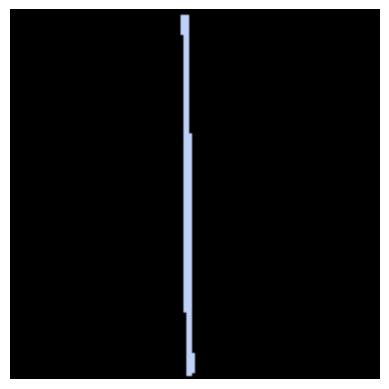

In [60]:
#Sampels: 10, 20, 26, 50, 57, 88, 83
#samples: 199, 78,1,3,26, 50,88
i=1
print('ALlFIveFeatuesofHaar',i)
image = phase1_prediction[i]
# Map the object colors to RGB colors
rgb_imageP = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_imageP[i, j] = color_map[image[i, j]]
plt.axis('off')
plt.imshow(rgb_imageP);

Real: 1
[0 1]


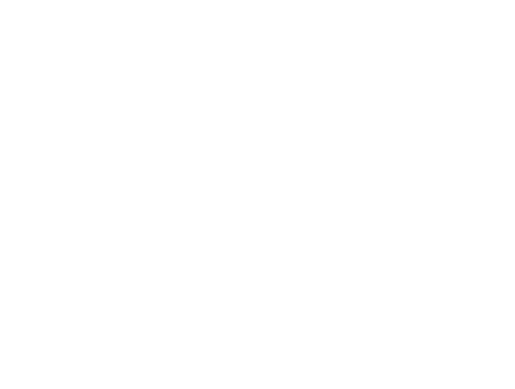

 Ground truth: 127


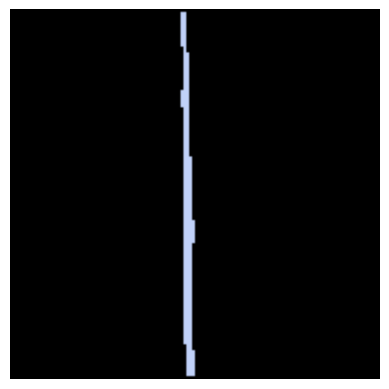

In [63]:
i=1
image = phase1_test[i]
print('Real:',i)
plt.axis('off')
#plt.imshow(X_test1[i])
print(np.unique(phase1_test[i]))
plt.show()
# Map the object colors to RGB colors
rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_image[i, j] = color_map[image[i, j]]
print(' Ground truth:',i)
plt.axis('off')
plt.imshow(rgb_image)

In [ ]:
label_mapping = {
    'background': 0,
    'crack': 1,
    'spiral_crack': 1,
    'hole': 2,
    'root': 3,
    'roots': 3,
    'Pipe_Deformed': 4,
    'deformation': 4,
     'fracture': 5,
    'erosion': 6,
     'encrustation': 6,
    'joint': 7,'joints':7,
    'joint_offset':7,'offset':7,
     'loose_gasket':8
}
